# Aviso

Esse material foi desenvolvido por Igor Peretta para a disciplina _FEELT31526 Sinais e Multimídia_ (Ago/2020), a partir do material criado para [_Think DSP: Digital Signal Processing in Python_](http://greenteapress.com/thinkdsp/html/index.html), de Allen B. Downey (Copyright 2014), acessado em sua versão 1.1.2 com licença de uso [CC-BY-NC-SA 4.0](http://creativecommons.org/licenses/by-nc-sa/4.0/).

### **Pré-requisitos**

In [3]:
import os 
if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
if not os.path.exists('suporte/FB.csv'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/FB.csv -P suporte/
if not os.path.exists('suporte/180960__kleeb__gunshot.wav'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/180960__kleeb__gunshot.wav -P suporte/
if not os.path.exists('suporte/92002__jcveliz__violin-origional.wav'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/92002__jcveliz__violin-origional.wav -P suporte/

In [4]:
import thinkdsp as tdsp
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact, fixed, Button, IntSlider, FloatSlider

In [5]:
def graph_size(n):
    """Função auxiliar para definir tamanho dos gráficos"""
    return (n*(1+5**0.5)/2, n)

def reset_button(defaults={}):
    """Função auxiliar para criar botões"""
    def on_button_clicked(_):
        for k, v in defaults.items(): 
            k.value = v
    button = Button(description='Reset')
    button.on_click(on_button_clicked)
    display(button)
    
def print_some_elements(array, n=10, starts_with=""):
    """Função auxiliar para imprimir elementos de início e fim de uma lista"""
    if starts_with:
        print(starts_with, end="")
    for n in range(n):
        print(f"{array[n]:.2g}", end=", ")
    print('...', end=" ")
    for n in range(n, 1, -1):
        print(f"{array[-n]:.2g}", end=", ")
    print(f"{array[-1]:.2g} : length={len(array)}")

---

# **Aula 04a: Suavização**

A suavização é uma operação que tenta remover variações de curto prazo de um sinal para revelar tendências de longo prazo. Por exemplo, se você plotar as mudanças diárias no preço de uma ação, ela parecerá barulhenta; um operador de alisamento pode tornar mais fácil ver se o preço está geralmente subindo ou descendo com o tempo.

Um algoritmo de suavização comum é uma média móvel, que calcula a média dos valores $n$ anteriores, para algum valor de $n$.

Como primeiro exemplo, vamos analisar os [preços de fechamento diários das ações do Facebook](https://finance.yahoo.com/quote/FB/history?period1=1337299200&period2=1585353600&interval=1d&filter=history&frequency=1d), de seu IPO em 2012-05-18 a 2020-03-27 (observação: o conjunto de dados inclui apenas dias de negociação).

In [4]:
df = pd.read_csv('suporte/FB.csv', header=0, parse_dates=[0])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
1,2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2,2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
3,2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
4,2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


In [5]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1972,2020-03-23,149.660004,152.309998,142.250000,148.100006,148.100006,29830800
1973,2020-03-24,155.210007,161.309998,152.570007,160.979996,160.979996,30440400
1974,2020-03-25,158.919998,162.990005,153.059998,156.210007,156.210007,35184300
1975,2020-03-26,158.250000,164.000000,157.020004,163.339996,163.339996,26556800
1976,2020-03-27,158.199997,160.089996,154.750000,156.789993,156.789993,24861900


Extraia os preços de fechamento e dias desde o início da série:

In [6]:
close = df['Close']
dates = df['Date']
days = (dates - dates[0]) / np.timedelta64(1,'D')

Façamos uma janela para calcular uma média móvel de *30 dias*. Para calcular a média móvel deste sinal, nossa janela terá com 30 elementos, sendo normalizada para que a soma dos elementos seja 1 (soma ponderada para cálculo de média).

In [7]:
def window(M, length_signal=None):
    window = np.ones(M)
    window /= sum(window) # normalização, soma = 1, soma ponderada para cálculo de média
    if length_signal:
        ans = np.zeros(length_signal)
        ans[:len(window)] = window
        return ans
    else:
        return window

def roll_window(window, N):
    if N <= 0 or N % len(window) == 0:
        return window
    else:
        N %= len(window) 
        tmp = np.zeros(window.shape)
        tmp[N:] = window[:-N]
        tmp[:N] = window[-N:]
        return tmp
    
def smoothed(signal, M):
    ans = np.zeros(signal.shape)
    for i in range(len(signal)):
        ans[i] = np.sum(roll_window(window(M, len(signal)), i)*signal)
    return ans

M = 30
smooth = smoothed(close, M)

@interact(M=fixed(M), desloca=(0, len(close)-M, 10))
def show_window(desloca=0):
    wnd = roll_window(window(M, len(close)), desloca)
    s = np.sum(wnd*close)
    d = np.sum(days*wnd)
    
    fig, ax1 = plt.subplots(figsize=graph_size(7))
    color = 'tab:orange'
    ax1.set_xlabel('Tempo (s)')
    ax1.set_ylabel('janela', color=color)
    ax1.plot(days, wnd, color=color)
    ax1.annotate(f'  Média = {s:0.2f}', (0, 0.03), color='r')
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('fechamento', color=color)
    ax2.plot(days, close, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.plot(days[M//2:desloca+M//2], smooth[:desloca], 'r')
    ax2.scatter(d, s, 64, color='r', marker='x', zorder=5)
    fig.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='desloca', max=1947, step=10), Output()), _dom_classes=('…

Podemos também fazer uso de uma operação matemática para fazer essa janela se deslocar em referência ao sinal ao mesmo tempo que opera resultando em diferentes valores a cada um desses deslocamentos. Essa operação é conhecida como convolução. Buscamos então a convolução dessa janela com os dados de preço de fechamento:

In [8]:
M = 30
wnd = window(M)
smoothed_stock = np.convolve(close, wnd, mode='valid')
smoothed_days = days[M//2: len(smoothed_stock) + M//2]

O `mode=valid` da função `numpy.convolve` utilizada significa que a convolução só é calculada quando a janela se sobrepõe completamente ao sinal. Vamos analizar os sinais originais e suavizados.

In [9]:
defaults = [max(days), max(days)//2]
slider1 = IntSlider(min=10, max=max(days), value=defaults[0], step=10)
slider2 = IntSlider(min=min(days), max=max(days), value=defaults[1], step=1)
reset_button(defaults={slider1: defaults[0], slider2: defaults[1]})

@interact(janela=slider1, dia_central=slider2)
def show_stock_prices(janela, dia_central):
    plt.figure(figsize=graph_size(7))
    plt.plot(days, close, color='gray', alpha=0.6, label='fechamento diário')
    plt.plot(smoothed_days, smoothed_stock, color='r', alpha=0.6, label='média de 30 dias')
    plt.legend(fontsize=14)
    plt.xlabel('Tempo (dias)', fontsize=14)
    plt.ylabel('Preço (USD)', fontsize=14)
    plt.xlim([max(min(days), dia_central-janela//2), min(dia_central+janela//2, max(days))])
    plt.grid('on')

Button(description='Reset', style=ButtonStyle())

interactive(children=(IntSlider(value=2870, description='janela', max=2870, min=10, step=10), IntSlider(value=…

A linha cinza são os dados brutos, a linha avermelhada mostra a média móvel de 30 dias. A suavização remove as mudanças mais extremas e torna mais fácil ver as tendências de longo prazo.

## **Suavizando sinais de som**

Vamos experimentar com sinais de som. Considere uma onda dente de serra com a complexidade de seus harmônicos:

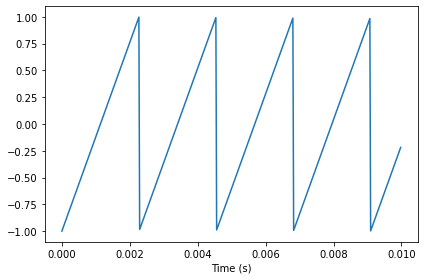

In [10]:
from thinkdsp import SawtoothSignal

signal = SawtoothSignal(freq=440)
wave = signal.make_wave(duration=1.0, framerate=44100)
segment = wave.segment(duration=0.01)
segment.plot()
tdsp.decorate(xlabel='Time (s)')

Criaremos uma janela para somar e dividir apenas um trecho do sinal. O sinal da janela será extendido com zeros para poder ser do mesmo tamanho do original:

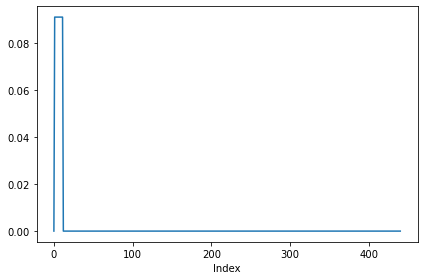

In [11]:
def zero_pad(array, n):
    """Amplia um sinal com zeros.

    array: NumPy array
    n: tamanho do sinal resultante

    returna: nova NumPy array
    """
    res = np.zeros(n)
    res[:len(array)] = array
    return res

N = len(segment)
window = np.ones(11)
window /= sum(window)
padded = zero_pad(window, N)
plt.plot(np.roll(padded, 1))
tdsp.decorate(xlabel='Index')

Vamos gerar o sinal resultante, "rolando" nossa janela um índice por vez:

In [12]:
smoothed = np.zeros(N)
rolled = padded.copy()
for i in range(N):
    smoothed[i] = sum(rolled * segment.ys) # soma o resultado da multiplicação dos sinais
    rolled = np.roll(rolled, 1) # desloca janela de 1 amostra

Comparando o original com o suavizado:

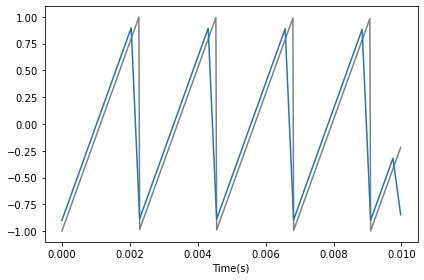

In [13]:
segment.plot(color='gray')
smooth = tdsp.Wave(smoothed, framerate=wave.framerate)
smooth.plot()
tdsp.decorate(xlabel='Time(s)')

Usando a função otimizada `numpy.convolve` que realiza a mesma operação:

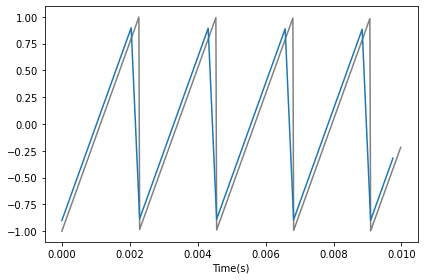

In [14]:
segment.plot(color='gray')
ys = np.convolve(segment.ys, window, mode='valid')
smooth2 = tdsp.Wave(ys, framerate=wave.framerate)
smooth2.plot()
tdsp.decorate(xlabel='Time(s)')

A linha cinza é o sinal original; a linha mais escura é o sinal suavizado. O sinal suavizado começa a aumentar quando a borda de ataque da janela atinge a primeira transição e nivela quando a janela cruza a transição. Como resultado, as transições são menos abruptas e os cantos menos nítidos.

In [15]:
wave.make_audio()

In [16]:
wave_smooth = tdsp.Wave(np.convolve(wave.ys, window, mode='same'), framerate=wave.framerate)
wave_smooth.make_audio()

Se você ouvir o sinal suavizado, soará menos zumbido e levemente abafado.

---

# **Aula 04b: Convolução**

## **Diferença entre correlação cruzada e convolução**

O laço utilizado na suavização na seção anterior realmente calcula a *correlação cruzada*:

$\large (f \star g)[n] = \displaystyle\sum_{m=0}^{N-1} f[m]\cdot g[n+m]$

onde $f$ é um vetor com os valores de amplitude de uma onda com comprimento $N$, $g$ é uma janela e $\star$ é o símbolo de correlação cruzada. Para calcular o $n$-ésimo elemento do resultado, deslocamos $g$ para a direita, e é por isso que o índice é $n + m$.

A definição de **convolução** é ligeiramente diferente:

$\large (f \ast g)[n] = \displaystyle\sum_{m=0}^{N-1} f[m]\cdot g[n-m]$

O símbolo $\ast$ representa a convolução. A diferença está no índice de $g$: $m$ foi negado, então a soma itera os elementos de $g$ de trás pra frente (assumindo que os índices negativos retornem ao final do vetor).

Como a janela que usamos nesse exemplo é _simétrica_, a correlação cruzada e a convolução _produzem o mesmo resultado_. Quando usarmos outras janelas, teremos que ser mais cuidadosos.

In [17]:
@interact(tipo_janela=['simétrica', 'assimétrica'], centro_janela=(2, 47, 1), stem=True, inverter=True)
def show_convolution(tipo_janela='simétrica', centro_janela=2, stem=True, inverter=True):
    f = lambda t : 2*np.exp(-(t-25)**2/50)
    t = np.array(range(0, 50))
    signal = f(t)
    signal[signal < 0.01] = 0
    signal[0:19] = 0
    signal[signal > 0.8] = 1
    signal[8:19] = list(1.2-i/10 for i in range(11))
    N = len(signal)
    window = np.array([0.75]*5 if tipo_janela == 'simétrica' else [0.15, 0.3, 0.45, 0.6, 0.75])
    if inverter:
        window = window[::-1]
    padded = np.zeros(signal.shape)
    idx = list(range(max(0, centro_janela-2), min(centro_janela+3, N)))
    padded[idx] = window
    conv = signal*padded
    plt.figure(figsize=graph_size(11))
    plt.subplot(211)
    if stem:
        plt.stem(t, signal, basefmt='gray', linefmt='bo', markerfmt='bo', use_line_collection=True)
        plt.stem(t, padded, basefmt='gray', linefmt='ro', markerfmt='ro', use_line_collection=True)
        plt.stem(t, signal*padded, basefmt='gray', linefmt='mo', markerfmt='go', use_line_collection=True)
    else:
        plt.plot(t, signal, 'b')
        plt.plot(t, padded, 'r')
        plt.plot(t, conv, 'g')
        plt.fill_between(t, conv, color='m')
    plt.annotate(f'  @{centro_janela}, convolução = {sum(conv):0.2g}',(0,1), fontsize=12, color='m')
    plt.subplot(212)
    c = np.convolve(signal, window, mode="same")
    plt.plot(t[0:centro_janela+1], c[0:centro_janela+1], 'g')
    plt.scatter(centro_janela, sum(conv), marker='*', color='m')
    plt.plot([centro_janela]*2, [0, sum(conv)], ':m')
    plt.annotate(f'  @{centro_janela}, convolução = {sum(conv):0.2g}',(centro_janela, sum(conv)), fontsize=12, color='m')
    plt.xlim([0, max(t)])
    plt.ylim([0, 1.1*max(c)])
    plt.ylabel('Sinal da convolução', fontsize=14)
        

interactive(children=(Dropdown(description='tipo_janela', options=('simétrica', 'assimétrica'), value='simétri…

## **Domínio da frequência**

A suavização torna as transições em um sinal menos abruptas e torna o som ligeiramente abafado. Vamos ver o efeito que essa operação tem no espectro.

A seguir, a a onda suavizada. O sinalizador `mode=same` indica que o resultado deve ter o mesmo comprimento que a entrada. Neste exemplo, ele incluirá alguns valores como se dessem a volta no vetor do sinal, mas tudo bem por enquanto.

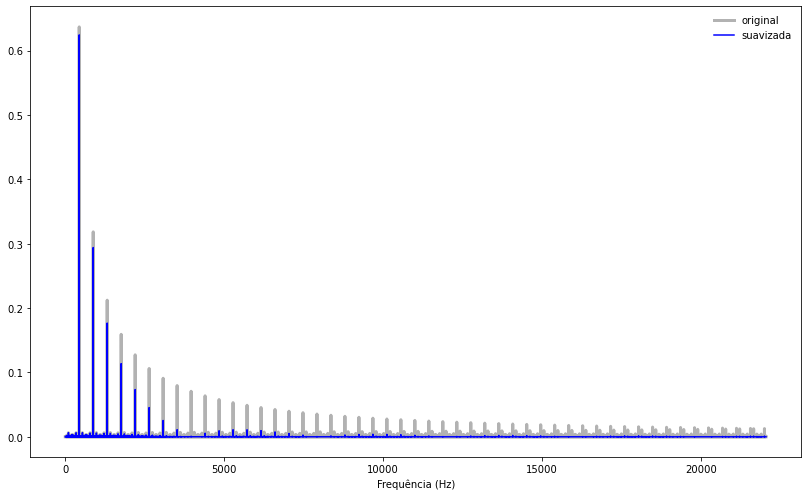

In [18]:
# original
spectrum = wave.make_spectrum()
spectrum.scale(2/len(wave))
# suavizada
convolved = np.convolve(wave.ys, window, mode='same')
smooth = tdsp.Wave(convolved, framerate=wave.framerate)
spectrum2 = smooth.make_spectrum()
spectrum2.scale(2/len(smooth))
# visualização
plt.figure(figsize=graph_size(7))
spectrum.plot(color='gray', linewidth=3, alpha=0.6, label='original')
spectrum2.plot(color='b', label='suavizada')
tdsp.decorate(xlabel='Frequência (Hz)')

A frequência fundamental é quase inalterada; os primeiros poucos harmônicos são atenuados e os harmônicos superiores são quase eliminados. Portanto, a suavização tem o efeito de um **filtro passa-baixa**. Para ver o quanto cada componente foi atenuado, podemos calcular a proporção dos dois espectros:

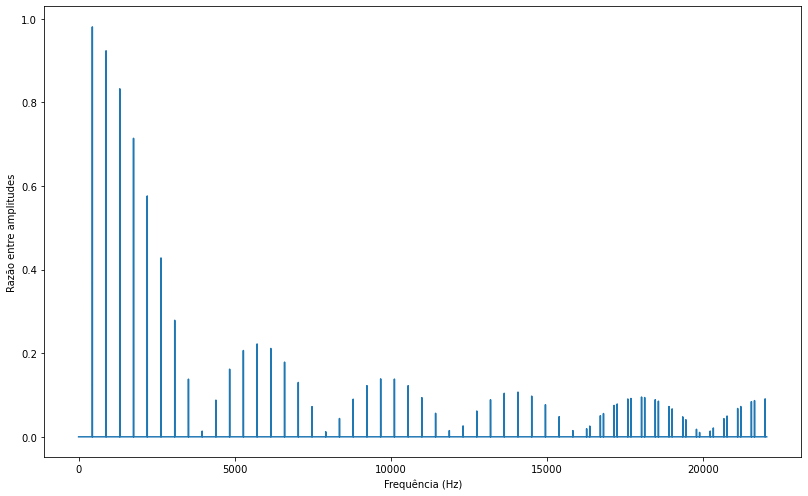

In [19]:
amps = spectrum.amps
amps2 = spectrum2.amps
ratio = amps2 / amps
plt.figure(figsize=graph_size(7))
ratio[amps<0.01] = 0
plt.plot(ratio)
tdsp.decorate(xlabel='Frequência (Hz)', ylabel='Razão entre amplitudes')

Podemos visualizar as proporções novamente, junto com a DFT da janela.

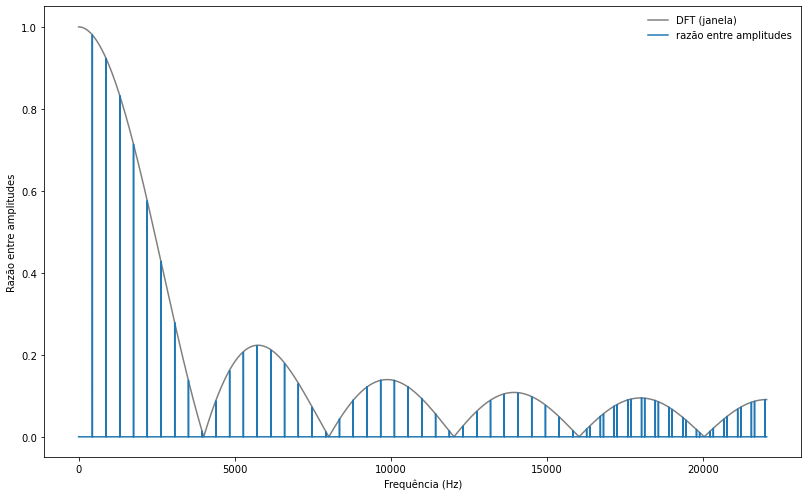

In [20]:
padded =  zero_pad(window, len(wave))
dft_window = np.fft.rfft(padded)

plt.figure(figsize=graph_size(7))
plt.plot(np.abs(dft_window), color='gray', label='DFT (janela)')
plt.plot(ratio, label='razão entre amplitudes')

tdsp.decorate(xlabel='Frequência (Hz)', ylabel='Razão entre amplitudes')

A variável `padded` contém a janela, preenchida com zeros para ter o mesmo comprimento da onda original. `dft_window` contém o DFT da janela de suavização. 

Como esperado, a proporção é alta para frequências baixas e cai em uma frequência de corte próxima a 4000 Hz. Mas há outra característica que não esperávamos: acima do corte, a proporção oscila entre 0 e 0,2. O que há com isso?

## **O teorema da convolução**

A resposta é o **teorema da convolução**. Declarado matematicamente:

$\large\mathrm{DFT}(f \ast g) = \mathrm{DFT}(f) \cdot \mathrm{DFT}(g)$


onde $f$ é um vetor com os valores de amplitude de uma onda e $g$ é uma janela. Em palavras, o teorema da convolução diz que se calcularmos a convolução de $f$ e $g$, e então calcularmos a DFT do resultado, obteremos a mesma resposta que quando calculamos a DFT de $f$ e de $g$ em separado, e então multiplicarmos os resultados por cada elemento. Mais concisamente, **a convolução no domínio do tempo corresponde à multiplicação no domínio da frequência**.

Logo, quando fazemos a convolução de uma onda e uma janela, é o mesmo que multiplicarmos o espectro da onda pelo espectro da janela.

Podemos ver que as razões entre as amplitudes mostradas anteriormente são exatamente as amplitudes em ` dft_window`. Ou seja, matematicamente dizemos:

$\large\dfrac{|\mathrm{DFT}(f \ast g)|}{|\mathrm{DFT}(f)|} = |\mathrm{DFT}(g)|$

Nesse contexto, a DFT de uma janela é denominado **filtro**. A saber:

- Para qualquer *janela de convolução* no *domínio do tempo*, existe um *filtro* correspondente no *domínio da frequência*. 
- E para qualquer *filtro* que pode ser expresso por multiplicação por elemento no *domínio da frequência*, há uma *janela* correspondente no *domínio do tempo*.

## **Filtro gaussiano**

A janela de média móvel que usamos na seção anterior é um filtro passa-baixa, mas não é muito bom. O DFT cai abruptamente no início, mas depois salta. Esses saltos são chamados de lóbulos laterais e estão lá porque a janela de média móvel é como uma onda quadrada, então seu espectro contém harmônicos de alta frequência que caem proporcionalmente a $\dfrac{1}{f}$, que é relativamente lento.

Podemos fazer melhor com uma janela gaussiana. O módulo `scipy.signal` fornece funções que calculam muitas janelas de convolução comuns, incluindo a gaussiana. Na função `scipy.signal.gaussian`, o parâmetro `M` é o número de elementos na janela e o parâmetro `std` é o desvio padrão da distribuição gaussiana usada para computá-la).

Vamos analisar uma janela gaussiana no tempo. Também vamos comparar com a janela de média móvel do exemplo anterior, também conhecida como "janela de vagão" (_boxcar window_) porque se parece com um vagão de trem retangular.

In [21]:
@interact(M=(2, 100, 1), std=(1, 20, 1), filtro=True, boxcar=True, equacao=True)
def plot_windows(M=11, std=2, filtro=True, equacao=True, boxcar=True):
    gaussian = scipy.signal.gaussian(M=M, std=std)
    gaussian /= sum(gaussian) # normalização, soma = 1
    window = np.ones(M)
    window /= sum(window) # normalização, soma = 1
    g = lambda a, b, c, x: a*np.exp(-(x-b)**2/(2*c**2))
    x = np.array(range(M))
    sg = g(1, (M-1)/2, std, x)
    sg /= sum(sg) # normalização, soma = 1
    if filtro:
        plt.plot(gaussian, label='filtro scipy.signal')
    if equacao:
        plt.plot(x, sg, label='equação')
    if boxcar:
        plt.plot(window, label='boxcar')
    tdsp.decorate(xlabel='Tempo (s)', ylabel='Amplitude')

interactive(children=(IntSlider(value=11, description='M', min=2), IntSlider(value=2, description='std', max=2…

É uma aproximação discreta da “curva em sino” gaussiana. 

Em matemática, a função gaussiana é definida:

$\large g(x) = a\cdot \exp \left( -\dfrac{(x - b)^2}{2c^2} \right)$

com constantes arbitrárias $a$, $b$ e $c$ ($c$ não pode ser zero). No contexto de filtros discretos, a janela de tamanho $M$ é calculada:

$\large g[n]\Biggm\lvert_{n=0}^{M-1} = a\cdot \exp \left( -\dfrac{(n - b)^2}{2c^2} \right)$

- $a$ é altura do pico da curva: $a=1$ é o sinal ordinário e $a=\dfrac{1}{\sum_{n=0}^{M-1}g[n]}$ é o sinal normalizado;
- $b$ é chamado tradicionalmente de média, ou o lugar do pico da curva: $b = \dfrac{M-1}{2}$ (note que o pico será enfatizado quando $M$ for ímpar);
- $c$ é chamado tradicionalmente de desvio padrão $\sigma$, é definido a partiir da frequência desejada de corte, com impacto no desempenho da janela como filtro passa-baixa.

  A relação entre $\sigma$ e a frequência de corte $f_c$ é dada por:

  $\large f_c = \sigma_f = \dfrac{F_s}{2\pi\sigma}$, onde $\sigma$ é dado em número de amostras e $F_s$ é a taxa de amostragem. 
  
  O valor de resposta do filtro Gaussiano nesta frequência de corte é igual a $\exp(-0.5) \approx 0.607$, ou seja, 60% do valor original da amplitude do componente naquela frequência.
  
  A relação entre $M$ e $\sigma$ deve ser a necessária para que a gaussiana atinja o zero. Como podemos esperar esse comportamento para $3\sigma$, podemos então considerar a relação:
  
  $\large M \geq 6\,\sigma$ ou $\large M \geq 6\,\sigma -1$ (se quisermos uma janela com tamanho ímpar (presença do pico).

Após o cálculo das amostras da janela, devemos preencher com zero até termos o tamanho do sinal que iremos convoluir (_zero padding_). A função `numpy.convolve` já faz essa operação de _zero padding_ no sinal de menor tamanho e, com o sinalizador `mode=same`, retorna o resultado da convolução com o mesmo tamanho do sinal de maior tamanho.

In [22]:
from thinkdsp import SawtoothSignal

@interact(M=(2, 120, 1), std=(1, 20, 1))
def plot_filter(M=11, std=2):
    signal = SawtoothSignal(freq=440)
    wave = signal.make_wave(duration=1, framerate=44100)
    spectrum = wave.make_spectrum()

    gaussian = scipy.signal.gaussian(M=M, std=std)
    gaussian /= sum(gaussian)
    
    fc = wave.framerate/(2*np.pi*std)

    ys = np.convolve(wave.ys, gaussian, mode='same')
    smooth =  tdsp.Wave(ys, framerate=wave.framerate)
    spectrum2 = smooth.make_spectrum()

    # plot the ratio of the original and smoothed spectrum
    amps = spectrum.amps
    amps2 = spectrum2.amps
    ratio = amps2 / amps    
    ratio[amps<560] = 0

    # plot the same ratio along with the FFT of the window
    padded =  zero_pad(gaussian, len(wave))
    dft_gaussian = np.fft.rfft(padded)
    
    plt.figure(figsize=graph_size(9))
    plt.subplot(311)
    wave.plot(color='gray', label='original')
    smooth.plot(label='suavizada')
    tdsp.decorate(xlabel='Tempo (s)', ylabel='Amplitude')
    plt.xlim([0, 5*signal.period])
    plt.subplot(312)
    spectrum.plot(color='gray', label='original')
    spectrum2.plot(label='suavizada')
    tdsp.decorate(xlabel='Frequência (Hz)', ylabel='Amplitudes')
    plt.subplot(313)
    plt.plot(np.abs(dft_gaussian), color='gray', label='Filtro Gaussiano')
    plt.plot(ratio, label='Razão entre amplitudes')
    plt.plot([0, fc], [np.exp(-0.5), np.exp(-0.5)], ':r')
    plt.plot([fc, fc], [0, np.exp(-0.5)], ':r')
    plt.scatter(fc, np.exp(-0.5), marker='*', color='r', zorder=5)
    plt.annotate(r'  $f_c =$' + f' {fc:.2f} Hz' + r'; $M \geq$'+ f'{std*6-1:.2f}', (fc, np.exp(-0.5)), color='r')
    tdsp.decorate(xlabel='Frequência (Hz)', ylabel='Razão entre amplitudes')
    plt.show()

interactive(children=(IntSlider(value=11, description='M', max=120, min=2), IntSlider(value=2, description='st…

Eu executei os cálculos das seções anteriores novamente com esta curva e gerei a Figura 8.7, que mostra a proporção dos espectros antes e depois da suavização, junto com a DFT da janela Gaussiana.

Como um filtro passa-baixa, a suavização gaussiana é melhor do que uma média móvel simples. Depois que a proporção cai, ela permanece baixa, com quase nenhum dos lóbulos laterais que vimos na janela do vagão. Portanto, ele corta melhor as frequências mais altas.

O motivo pelo qual ele funciona tão bem é que a DFT de uma curva gaussiana também é uma curva gaussiana. Portanto, a proporção cai em proporção a $\exp\left(-f^2\right)$, que é muito mais rápido do que $\dfrac{1}{f}$.

---

# **Aula 04c: DFT, IDFT, Convolução eficiente**

## **Transformada discreta de Fourier e inversa**

Antes de avançarmos no tópico de convolução, precisaremos resgatar as definições das **Transformada Discreta de Fourier (DFT)**, utilizada numericamente para obter um espectro relativo a um sinal discreto no domínio do tempo, e da **Transformada Discreta Inversa de Fourier (IDFT)**, utilizada numericamente para recuperar um sinal discreto a partir de seu espectro.

As implementações otimizadas, como em Python no módulo NumPy, utilizam o algoritmo da [**Transformada Rápida de Fourier (FFT)**](pt.wikipedia.org/wiki/Transformada_rápida_de_Fourier), considerado um dos 10 melhores algoritmos do século 20 pela revista _IEEE Computing in Science & Engineering_ nº 1 • Jan-Fev/2000 ([editorial, em inglês](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=814652); [índice, em inglês](https://ieeexplore.ieee.org/xpl/tocresult.jsp?isnumber=17639&punumber=5992)).

Para investigarmos definições matemáticas e algumas implementações diferentes em Python, vamos começar definindo um pequeno trecho de sinal (1 segundo com 128 amostras):

In [32]:
import math

# sinal a ser usado:
def x(t):
    signal = []
    for n in t: 
        signal.append(sum(1/a*math.cos(2*math.pi*a*5*n + math.pi/a) for a in range(1,6))) # Frequências = 5, 10, 15, 20, 25 Hz
    return signal

SR = 128 # taxa de amostragem = 128 Hz

# onda amostrada
t = list(i/SR for i in range(SR)) # tempo para amostras no intervalo aberto [0 , 1) em segundos
xn = x(t)
N = len(xn) # tamanho do sinal amostrado

# visualizações
print_some_elements(xn, starts_with="xn = ")
print_some_elements(t, starts_with="t = ")

plt.figure(figsize=graph_size(5))
plt.plot(t, xn, '-o')
plt.xlabel("Tempo (s)", fontsize=14)
plt.ylabel("xn, amplitudes", fontsize=14)
plt.grid('on');

xn = -0.49, -1.4, -2, -1.9, -1.1, -0.26, 0.24, 0.48, 0.72, 1, ... 0.21, 0.055, 0.036, -0.049, -0.31, -0.53, -0.45, -0.12, -0.0066 : length=128
t = 0, 0.0078, 0.016, 0.023, 0.031, 0.039, 0.047, 0.055, 0.062, 0.07, ... 0.93, 0.94, 0.95, 0.95, 0.96, 0.97, 0.98, 0.98, 0.99 : length=128


## **DFT**

### Definição matemática

  $\large X_k = \displaystyle\sum_{n=0}^{N-1} x_n\cdot \exp\left(-j\dfrac{2\pi}{N}kn\right)$, com $X_k \in \mathbb{C}$

### DFT: Implementação em Python

In [36]:
# DFT
Xk = []
for k in range(N): # primeiro "ciclo"
    Xk.append(sum(xn[n]*np.exp(-1j*2*np.pi/N*k*n) for n in range(N)))
    
# ajustes e outros cálculos para espectro
hs = list(map(abs, Xk))
hs = list(map(lambda x : x*2/N, hs))
hs = hs[0:N//2+1] # amostras relativas às frequências positivas
fs = list((i/(len(hs)-1))*SR/2 for i in range(len(hs))) # amostras no intervalo fechado [0 , SR/2] Hz

# visualizações
print_some_elements(Xk, n=6, starts_with="Xk = ")
print_some_elements(hs, starts_with="hs = ")
print_some_elements(fs, starts_with="fs = ")

plt.figure(figsize=graph_size(5))
plt.plot(fs, hs, '-o')
plt.xlabel("Frequência (Hz) PYTHON", fontsize=14)
plt.ylabel("Xk, amplitudes das magnitudes PYTHON", fontsize=14)
plt.grid('on');

Xk = 5e-15+0j, 3.8e-15+6.1e-15j, 1.7e-15+1.9e-15j, -9.7e-15-6e-15j, 2.1e-14-3.1e-14j, -64+1.6e-14j, ... -64-1.3e-12j, 4.5e-13+1.3e-13j, 2.6e-13+5.3e-13j, -7.3e-14-9.3e-16j, 1.8e-14+3.1e-15j : length=128
hs = 7.8e-17, 1.1e-16, 4e-17, 1.8e-16, 5.8e-16, 1, 2.9e-16, 4.7e-16, 2.3e-16, 6.4e-16, ... 6.3e-16, 2e-15, 1.1e-15, 1.2e-15, 7.1e-16, 5.8e-16, 2.2e-15, 1.8e-16, 4.4e-16 : length=65
fs = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ... 56, 57, 58, 59, 60, 61, 62, 63, 64 : length=65


### DFT: Módulo NumPy (uso o algoritmo da FFT)

Xk = 6.3e-15+0j, 1.5e-15+4.7e-15j, 5.1e-15+2.3e-15j, -6.5e-15-1.1e-15j, 2.7e-14-2.1e-14j, -64+5.8e-14j, ... 3.7e-15+1.1e-14j, 1.1e-14+4.3e-15j, -1.2e-14+2.6e-14j, -1.5e-14+4.7e-15j, -5.7e-15+0j : length=65
hs = 9.8e-17, 7.7e-17, 8.7e-17, 1e-16, 5.4e-16, 1, 2.7e-16, 1.2e-16, 2.6e-17, 3.7e-16, ... 1.5e-16, 2e-16, 2.2e-16, 1.8e-16, 1.8e-16, 1.9e-16, 4.4e-16, 2.4e-16, 8.9e-17 : length=65
fs = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ... 56, 57, 58, 59, 60, 61, 62, 63, 64 : length=65


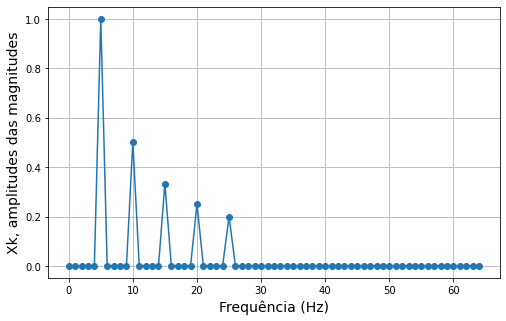

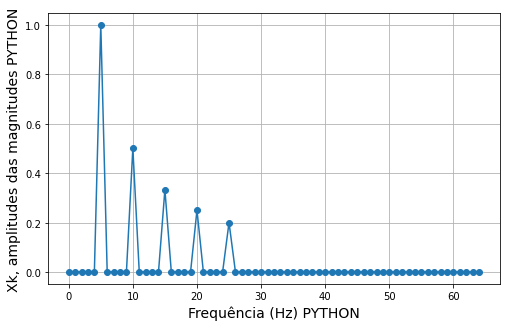

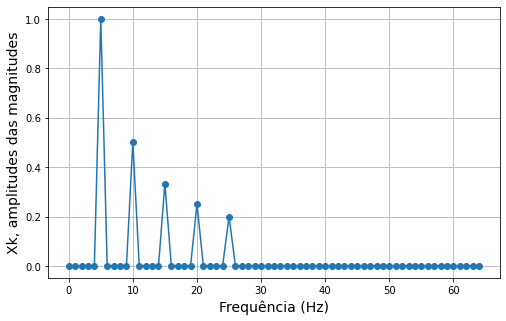

In [37]:
# onda amostrada
xn_numpy = np.array(xn)

# DFT
Xk_numpy = np.fft.rfft(xn_numpy)

# ajustes e outros cálculos para espectro
hs_numpy = np.abs(Xk_numpy)
hs_numpy *= 2/len(xn_numpy)
fs_numpy = np.fft.rfftfreq(len(xn_numpy), 1./SR)

# visualizações
print_some_elements(Xk_numpy, n=6, starts_with="Xk = ")
print_some_elements(hs_numpy, starts_with="hs = ")
print_some_elements(fs_numpy, starts_with="fs = ")

plt.figure(figsize=graph_size(5))
plt.plot(fs_numpy, hs_numpy, '-o')
plt.xlabel("Frequência (Hz)", fontsize=14)
plt.ylabel("Xk, amplitudes das magnitudes", fontsize=14)
plt.grid('on');

### DFT: Módulo ThinkDSP (encapsulamento de funções do NumPy)

Xk = 9.8e-17+0j, 2.3e-17+7.4e-17j, 7.9e-17+3.6e-17j, -1e-16-1.8e-17j, 4.2e-16-3.3e-16j, -1+9.1e-16j, ... 5.7e-17+1.7e-16j, 1.8e-16+6.8e-17j, -1.9e-16+4e-16j, -2.3e-16+7.4e-17j, -8.9e-17+0j : length=65
hs = 9.8e-17, 7.7e-17, 8.7e-17, 1e-16, 5.4e-16, 1, 2.7e-16, 1.2e-16, 2.6e-17, 3.7e-16, ... 1.5e-16, 2e-16, 2.2e-16, 1.8e-16, 1.8e-16, 1.9e-16, 4.4e-16, 2.4e-16, 8.9e-17 : length=65
fs = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ... 56, 57, 58, 59, 60, 61, 62, 63, 64 : length=65


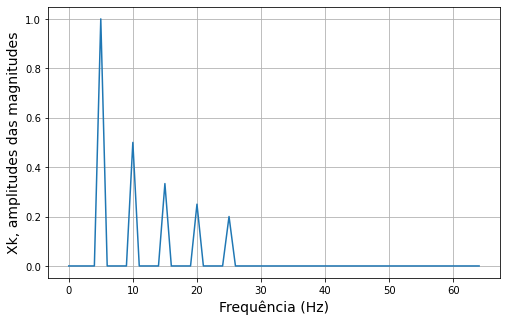

In [31]:
# onda amostrada
xn_tdsp = tdsp.Wave(xn, framerate=SR)
    
# DFT, ajustes e outros cálculos para espectro
spectrum = xn_tdsp.make_spectrum()
spectrum.scale(2/N) # para ver as amplitudes na proporção correta

# visualizações
print_some_elements(spectrum.hs, n=6, starts_with="Xk = ")
print_some_elements(spectrum.amps, starts_with="hs = ")
print_some_elements(spectrum.fs, starts_with="fs = ")

plt.figure(figsize=graph_size(5))
spectrum.plot()
plt.xlabel("Frequência (Hz)", fontsize=14)
plt.ylabel("Xk, amplitudes das magnitudes", fontsize=14)
plt.grid('on');

## **IDFT**

### Definição matemática

  $\large x_n = \dfrac{1}{N} \displaystyle\sum_{k=0}^{N-1} X_k \cdot \exp\left(j\dfrac{2\pi}{N}kn\right)$, com $x_n \in \mathbb{R}$ para espectros de sinais reais  
  
### IDFT: Implementação em Python

Parte imaginária máxima xn = 4.7e-14
xn = -0.49, -1.4, -2, -1.9, -1.1, -0.26, 0.24, 0.48, 0.72, 1, ... 0.21, 0.055, 0.036, -0.049, -0.31, -0.53, -0.45, -0.12, -0.0066 : length=128
t = 0, 0.0078, 0.016, 0.023, 0.031, 0.039, 0.047, 0.055, 0.062, 0.07, ... 0.93, 0.94, 0.95, 0.95, 0.96, 0.97, 0.98, 0.98, 0.99 : length=128


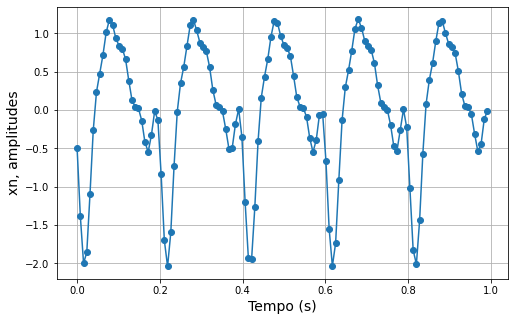

In [27]:
# IDFT
xn_new = []
for n in range(N):
    xn_new.append(1/N * sum(Xk[k]*np.exp(1j*2*np.pi/N*k*n) for k in range(N)))
t_new = list(i/SR for i in range(SR)) # tempo para amostras no intervalo aberto [0 , 1) em segundos
# -- ajuste numérico
print(f'Parte imaginária máxima xn = {max(i.imag for i in xn_new):.2g}')
xn_new = list(i.real for i in xn_new) # convertendo para sinal real

# visualizações
print_some_elements(xn_new, starts_with="xn = ")
print_some_elements(t_new, starts_with="t = ")

plt.figure(figsize=graph_size(5))
plt.plot(t, xn_new, '-o')
plt.xlabel("Tempo (s)", fontsize=14)
plt.ylabel("xn, amplitudes", fontsize=14)
plt.grid('on');

### IDFT: Módulo NumPy (usa o algoritmo da inversa da FFT)

xn = -0.49, -1.4, -2, -1.9, -1.1, -0.26, 0.24, 0.48, 0.72, 1, ... 0.21, 0.055, 0.036, -0.049, -0.31, -0.53, -0.45, -0.12, -0.0066 : length=128
t = 0, 0.0078, 0.016, 0.023, 0.031, 0.039, 0.047, 0.055, 0.062, 0.07, ... 0.93, 0.94, 0.95, 0.95, 0.96, 0.97, 0.98, 0.98, 0.99 : length=128


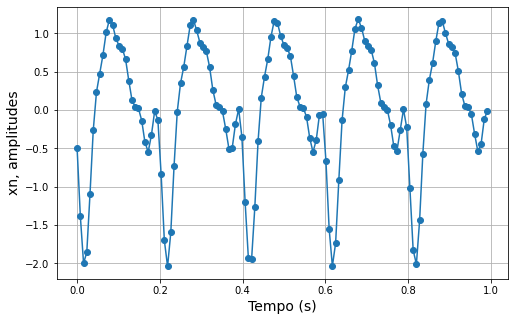

In [28]:
# IDFT
xn_new_numpy = np.fft.irfft(Xk_numpy)
t_new_numpy = np.linspace(0, (N-1)/SR, SR)

# visualizações
print_some_elements(xn_new_numpy, starts_with="xn = ")
print_some_elements(t_new_numpy, starts_with="t = ")

plt.figure(figsize=graph_size(5))
plt.plot(t_new_numpy, xn_new_numpy, '-o')
plt.xlabel("Tempo (s)", fontsize=14)
plt.ylabel("xn, amplitudes", fontsize=14)
plt.grid('on');

### IDFT: Módulo ThinkDSP (encapsulamento de funções do NumPy)

xn = -0.49, -1.4, -2, -1.9, -1.1, -0.26, 0.24, 0.48, 0.72, 1, ... 0.21, 0.055, 0.036, -0.049, -0.31, -0.53, -0.45, -0.12, -0.0066 : length=128
t = 0, 0.0078, 0.016, 0.023, 0.031, 0.039, 0.047, 0.055, 0.062, 0.07, ... 0.93, 0.94, 0.95, 0.95, 0.96, 0.97, 0.98, 0.98, 0.99 : length=128


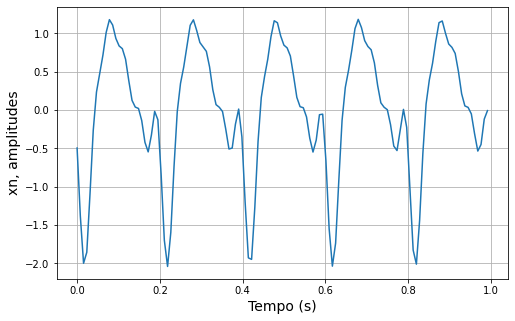

In [29]:
# IDFT
spectrum.scale(N/2) # reverter para calcular as amplitudes corretas
xn_new_tdsp = spectrum.make_wave()

# visualizações
print_some_elements(xn_new_tdsp.ys, starts_with="xn = ")
print_some_elements(xn_new_tdsp.ts, starts_with="t = ")

plt.figure(figsize=graph_size(5))
xn_new_tdsp.plot()
plt.xlabel("Tempo (s)", fontsize=14)
plt.ylabel("xn, amplitudes", fontsize=14)
plt.grid('on');

## **O algoritmo da Transformada Rápida de Fourier (FFT)**

Vamos começar com a DFT, um sinal $X$ em função de um índice $k$ (representado no domínio da frequência) calculado a partir de $x$ índice $n$ (no tempo).

Analizando a transformada de Fourier em subseqüências indexadas pares $(n_\mathrm{par} \to 2r)$ e ímpares $(n_\mathrm{ímpar} \to 2r+1)$ e com um pouco de álgebra, conseguimos reconhecer na expressão a soma de dois termos:

$\begin{array}{rcl}
\large X_k & = & \large \displaystyle\sum_{n=0}^{N-1} x_n\cdot \exp\left(-j\dfrac{2\pi}{N}kn\right)\\ 
\large X_k & = & \large  \left[\displaystyle\sum_{r=0}^{N/2-1} x_{2r}\cdot \exp\left(-j\dfrac{2\pi}{N}k\cdot(2r)\right)\right] + \left[\displaystyle\sum_{r=0}^{N/2-1} x_{2r+1}\cdot \exp\left(-j\dfrac{2\pi}{N}k\cdot(2r+1)\right)\right]\\
\large & = & \large  \left[\displaystyle\sum_{r=0}^{N/2-1} x_{2r}\cdot \exp\left(-j\dfrac{2\pi}{N}k\cdot(2r)\right)\right] + \exp\left(-j\dfrac{2\pi}{N}k\right) \cdot \left[\displaystyle\sum_{r=0}^{N/2-1} x_{2r+1}\cdot \exp\left(-j\dfrac{2\pi}{N}k\cdot(2r)\right)\right]\\
\large & = & \large  \left[\displaystyle\sum_{r=0}^{N/2-1} x_{2r}\cdot \exp\left(-j\dfrac{2\pi}{N/2}kr\right)\right] + \exp\left(-j\dfrac{2\pi}{N}k\right) \cdot \left[\displaystyle\sum_{r=0}^{N/2-1} x_{2r+1}\cdot \exp\left(-j\dfrac{2\pi}{N/2}kr\right)\right]\\
 & = & \large  X_k^{par} + \exp\left(-j\dfrac{2\pi}{N}k\right) \cdot X_k^{ímpar}\\
\end{array}$

Assim, podemos calcular a DFT para os termos pares e ímpares simultaneamente. Para melhorar ainda mais o algoritmo, basta aplicar a abordagem de "dividir e conquistar", reduzindo pela metade o custo computacional a cada iteração. Em outras palavras, podemos continuar a dividir o tamanho do problema até ficarmos com grupos de dois e, em seguida, calcular diretamente as transformadas discretas de Fourier para cada um desses pares. Desde que o tamanho do sinal seja uma **potência de 2**, o número máximo de vezes que você pode dividir em duas metades iguais é dado por $p = \log(N)$. Com isso, a complexidade original da DFT, $\mathcal{O}\left(N^2\right)$, é reduzida ao aplicar o FFT para $\mathcal{O}\left(N\,\log N\right)$.

Verificando e comparando implementações:

In [30]:
def DFT(x):
    N = x.shape[0]
    n = np.reshape(np.arange(N), (1, N))
    k = np.transpose(n)
    return np.sum(x*np.exp(-1j*2*np.pi/N*(k @ n)), axis=1)

def FFT(x):
    N = x.shape[0]
    if N % 2 > 0:
        raise ValueError("o tamanho do sinal deve ser uma potência de 2")
    elif N <= 2:
        return DFT(x)
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        terms = np.exp(-1j*2*np.pi/N*np.arange(N))
        return np.concatenate([X_even + terms[:N//2] * X_odd, X_even + terms[N//2:] * X_odd])

x = np.random.random(1024)
np.allclose(DFT(x), FFT(x))

True

In [31]:
%timeit DFT(x)
%timeit FFT(x)
%timeit np.fft.fft(x)

74.9 ms ± 4.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.3 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.9 µs ± 4.52 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## **Uma convolução eficiente**

Uma das razões pelas quais o FFT é um algoritmo tão importante é que, combinado com o Teorema da Convolução, ele fornece uma maneira eficiente de calcular a convolução, correlação cruzada e autocorrelação.

Novamente, o Teorema da Convolução afirma

$\large\mathrm{DFT}(f \ast g) = \mathrm{DFT}(f) \cdot \mathrm{DFT}(g)$

Portanto, uma maneira de calcular uma convolução é:

$\large f \ast g = \mathrm{IDFT}\left(\mathrm{DFT}(f) \cdot \mathrm{DFT}(g)\right)$

onde IDFT (_Inverse Discrete Fourier Transform_) é a operação inversa da DFT. Uma implementação simples de convolução -- laços aninhados -- possui complexidade $O\left(N^2\right)$; a estratégia de cálculo com as transformadas de Fourier, usando FFT, possui complexidade $O\left(N\,\log N\right)$.

Para aprofundarmos essa idéia, vamos analisar a DFT e a IDFT, ambas implementadas com o uso do algoritmo FFT:

In [67]:
@interact(zoom=(0.005, 0.05, 0.001), n_amostras=(441, 44100, 693), M=(2, 120, 1), std=(1, 20, 1), fft=True, conv=False, show=False)
def show_convolution(zoom=0.1, n_amostras=22050, M=11, std=2, fft=True, conv=False, show=False):
    # sinal
    SR = 44100
    signal = SawtoothSignal(freq=440)
    wave = signal.make_wave(duration=(n_amostras if n_amostras%2 == 0 else n_amostras - 1)/SR, framerate=SR)
    # -- convertendo para numpy
    xn = wave.ys
    t = wave.ts
    N = len(xn)

    # janela extendida com zeros
    window = scipy.signal.gaussian(M=M, std=std)
    window /= sum(window)
    padded = np.zeros(N)
    padded[:len(window)] = window
    
    fc = SR/(2*np.pi*std)
    M_min = 6*std-1

    # convolução
    x_conv = np.fft.irfft(np.fft.rfft(xn)*np.fft.rfft(padded))
    x_conv = np.roll(x_conv, -M//2+1) # acerto de fase
    x_conv2 = np.convolve(xn, window, mode="same") # Usa a convolução direta ou algoritmo de convolução FFT dependendo de qual é mais rápido.
    if show:
        print_some_elements(x_conv, starts_with="x_conv fft = ")
        print_some_elements(x_conv, starts_with="x_conv2 np.convolve = ")

    # visualizações
    plt.figure(figsize=graph_size(7))
    plt.plot(t, xn, color='gray', label='original')
    if fft:
        plt.plot(t, x_conv, label='convoluído fft')
    if conv:
        plt.plot(t, x_conv2, label='np.convolve')
    plt.annotate(r'  $f_c =$' + f' {fc:.2f} Hz' + r'; $M \geq$'+ f'{M_min:.2f}', (0, -1), color='r', fontsize=14)
    plt.xlabel("Tempo (s)", fontsize=14)
    plt.ylabel("xn, amplitudes", fontsize=14)
    plt.legend()
    plt.grid('on')
    plt.xlim([0, zoom])
    plt.ylim([-1.1, 1.1])
    plt.show()

interactive(children=(FloatSlider(value=0.05, description='zoom', max=0.05, min=0.005, step=0.001), IntSlider(…

---

# **Aula 04d: Sistemas Lineares Invariantes no Tempo**

No contexto do processamento de sinal, um sistema é uma representação abstrata de qualquer coisa que recebe um sinal como entrada e produz um sinal como saída. Por exemplo, um amplificador eletrônico é um circuito que recebe um sinal elétrico como entrada e produz um sinal (mais alto) como saída. Como outro exemplo, ao ouvir uma apresentação musical, você pode pensar na sala como um sistema que pega o som da apresentação no local onde é gerado e produz um som um tanto diferente no local onde você o ouve.

Um [sistema linear invariante no tempo](https://pt.wikipedia.org/wiki/Sistema_linear_invariante_no_tempo) (LIT) é um sistema com estas duas propriedades:

- **Linearidade:** se você colocar duas ou mais entradas no sistema ao mesmo tempo, o resultado será a soma de suas saídas. Matematicamente, se uma entrada $x_1$ produz a saída $y_1$ e outra entrada $x_2$ produz $y_2$, então $a\cdot x_1 + b\cdot x_2$ produz $a\cdot y_1 + b\cdot y_2$, onde $a$ e $b$ são escalares.
- **Invariância de tempo:** O efeito do sistema não varia ao longo do tempo tampouco depende do estado do sistema. Portanto, se as entradas $x_1$ e $x_2$ forem deslocadas no tempo, suas saídas $y_1$ e $y_2$ serão deslocadas da mesma quantidade, mas permanecem idênticas no resto.

Muitos sistemas físicos têm essas propriedades, pelo menos aproximadamente. Por exemplo:

- Circuitos que contêm apenas resistores, capacitores e indutores são LIT, na medida em que os componentes se comportam como seus modelos idealizados;
- Os sistemas mecânicos que contêm molas, massas e pistões também são LIT, assumindo como lineares as molas (força proporcional ao deslocamento) e os pistões (força proporcional à velocidade);
- A mídia que transmite som (incluindo ar, água e sólidos) é bem modelada por sistemas LIT;
- etc.

Os sistemas LIT são descritos por _equações diferenciais lineares_ e as soluções dessas equações são _ondas senoidais complexas_ (veja mais em https://pt.wikipedia.org/wiki/Equação_diferencial_linear). Este resultado fornece um algoritmo para calcular o efeito de um sistema LIT em um sinal de entrada:

- Expresse o sinal como a soma de componentes senoidais complexas;
- Para cada componente de entrada, calcule o componente de saída correspondente;
- Adicione os componentes de saída.

Note que o algoritmo é bastante similar ao que usamos para a convolução eficiente. Este processo é chamado de **decomposição espectral** porque "decompomos" o sinal de entrada em seus componentes espectrais.

A fim de aplicar esse processo a um sistema LIT, temos que caracterizar o sistema ao encontrar seu efeito em cada componente do sinal de entrada. Para sistemas mecânicos, verifica-se que existe uma maneira simples e eficiente de fazer isso: você chuta o sistema e grava a saída.

Tecnicamente, o "chute" é chamado de **impulso** e a saída é chamada de **resposta ao impulso**. Você pode se perguntar como um único impulso pode caracterizar completamente um sistema. Você pode ver a resposta calculando o DFT de um impulso. Aqui está um vetor (onda) com um impulso em $t = 0$:

[1. 0. 0. 0. 0. 0. 0. 0.]


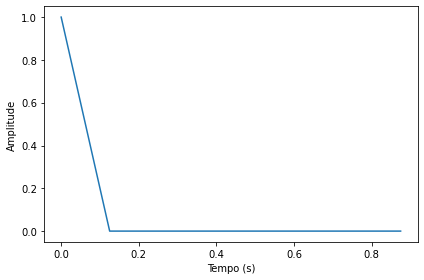

In [68]:
from thinkdsp import Wave

impulse = np.zeros(8)
impulse[0] = 1
wave = Wave(impulse, framerate=8)
print(wave.ys)
wave.plot()
tdsp.decorate(xlabel='Tempo (s)', ylabel='Amplitude')

O DFT de um impulso é todo um, o que significa que o impulso contém a mesma energia em todas as frequências. Portanto, testar um sistema com um impulso é como testar todos os componentes de frequência ao mesmo tempo.

[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]


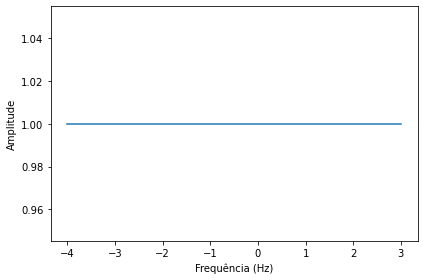

In [69]:
impulse_spectrum = wave.make_spectrum(full=True)
print(impulse_spectrum.hs)
impulse_spectrum.plot()
tdsp.decorate(xlabel='Frequência (Hz)', ylabel='Amplitude')

O espectro é constituído por unidades; ou seja, **um impulso é a soma de componentes com magnitudes iguais em todas as frequências**. Este espectro _não deve ser confundido com ruído branco_, que tem a mesma potência média em todas as frequências, mas varia em torno dessa média.

Quando você testa um sistema inserindo um impulso, está testando a resposta do sistema em todas as frequências de interesse. E você consegue testar todas as frequências ao mesmo tempo. Uma vez que o sistema é linear, testes simultâneos não interferem uns com os outros.

## **Janelas e filtros**

Para mostrar por que esse tipo de caracterização de sistema funciona, temos um exemplo simples: uma média móvel de 2 elementos. Podemos pensar nessa operação como um sistema que recebe um sinal como entrada e produz um sinal um pouco mais suave como saída. Neste exemplo, conhecemos a janela no tempo:

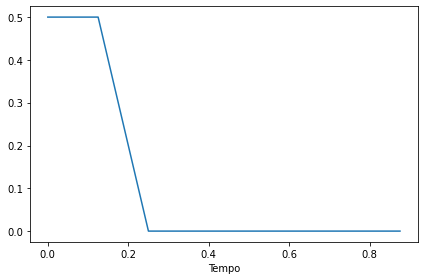

In [70]:
window_array = np.array([0.5, 0.5, 0, 0, 0, 0, 0, 0])
window = tdsp.Wave(window_array, framerate=8)
window.plot()
tdsp.decorate(xlabel='Tempo')

Portanto, podemos calcular o filtro correspondente calculando a DFT da janela; note que o filtro que corresponde a uma janela de média móvel é um filtro passa-baixa com a forma aproximada de uma curva gaussiana.

[1.         0.92387953 0.70710678 0.38268343 0.         0.38268343
 0.70710678 0.92387953]


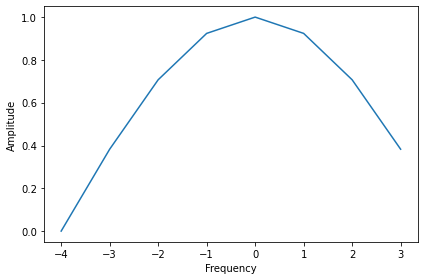

In [71]:
filtr = window.make_spectrum(full=True)
print(filtr.amps)
filtr.plot()
tdsp.decorate(xlabel='Frequency', ylabel='Amplitude')

Agora, imagine a situação mais comum que é a de não conhecermos nem a janela tampouco o filtro correspondente para um dado sistema de interesse. Como queremos caracterizar esse sistema, podemos fazer isso ao inserir um impulso em sua entrada e medindo a sua saída, a resposta ao impulso. Nesse exemplo, podemos calcular a resposta ao impulso multiplicando o espectro do impulso pelo filtro e, em seguida, convertendo o espectro resultante para uma onda:

In [72]:
product = impulse_spectrum * filtr
print(product.hs)

[1.        +0.j         0.85355339-0.35355339j 0.5       -0.5j
 0.14644661-0.35355339j 0.        +0.j         0.14644661+0.35355339j
 0.5       +0.5j        0.85355339+0.35355339j]


[ 5.00000000e-01  5.00000000e-01  0.00000000e+00  2.77555756e-17
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.77555756e-17]


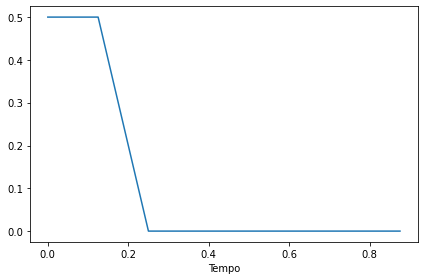

In [73]:
filtered = product.make_wave()
filtered.plot()
tdsp.decorate(xlabel='Tempo')
print(filtered.ys.real)

Como as todas componentes do espectro do impulso possuem magnitude unitária, o produto é idêntico ao filtro e a onda filtrada é idêntica à janela. Esse exemplo demonstra duas coisas:

- Como todas componentes do espectro de um impulso tem magnitude unitária, a DFT da _resposta ao impulso é idêntica ao filtro que caracteriza o sistema_.
- Portanto, a _resposta ao impulso é idêntica à janela de convolução_ que caracteriza o sistema.

## **Resposta acústica**

Em acústica, ara caracterizar a resposta acústica de uma sala ou espaço aberto, uma maneira simples de gerar um impulso (aproximado) seria bater as palmas da mão, estourar um balão ou disparar uma arma. Um rápido estouro impulsiona o sistema; o som que ouvimos na sequência é a resposta ao impulso do ambiente.

Como exemplo, vamos usar a gravação de um tiro para caracterizar a sala onde a arma foi disparada e, em seguida, usar essa resposta ao impulso para simular o efeito dessa mesma sala em uma outra gravação.

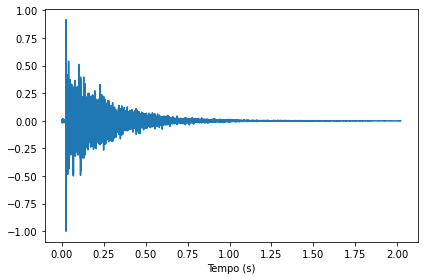

In [74]:
response = tdsp.read_wave('180960__kleeb__gunshot.wav')

start = 0.12 # para remover o silêncio antes do tiro, ajuste manual
response = response.segment(start=start)
response.shift(-start)

response.normalize()
response.plot()
tdsp.decorate(xlabel='Tempo (s)')

response.make_audio()

O espectro dessa gravação:

In [75]:
transfer = response.make_spectrum()

@interact(log_log=False)
def show_transfer(log_log):
    transfer.plot()
    if log_log:
        tdsp.decorate(xlabel='Frequência (Hz)', xscale='log', yscale='log')
    else:
        tdsp.decorate(xlabel='Frequência (Hz)')

interactive(children=(Checkbox(value=False, description='log_log'), Output()), _dom_classes=('widget-interact'…

Esse espectro é chamado de **função de transferência** porque contém informações sobre como o sistema transfere a entrada para a saída.

Agora podemos simular como uma gravação soaria se fosse tocada na mesma sala do tiro e gravada da mesma maneira. Aqui está a gravação de violino que usamos antes:

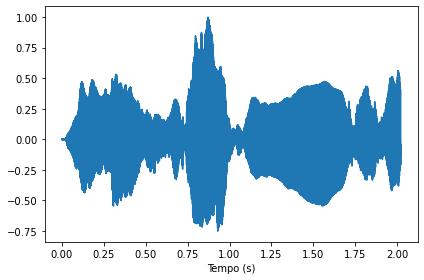

In [76]:
violin = tdsp.read_wave('92002__jcveliz__violin-origional.wav')

start = 0.11 # para remover o silêncio antes do violino, ajuste manual
violin = violin.segment(start=start)
violin.shift(-start)

# para facilitar a multiplicação a seguir
violin.truncate(len(response))
spectrum = violin.make_spectrum()

violin.normalize()
violin.plot()
tdsp.decorate(xlabel='Tempo (s)')

violin.make_audio()

E aqui, o espectro da gravação do violino:

In [77]:
spectrum = violin.make_spectrum()

@interact(log_log=False)
def show_violin(log_log):
    spectrum.plot()
    if log_log:
        tdsp.decorate(xlabel='Frequência (Hz)', xscale='log', yscale='log')
    else:
        tdsp.decorate(xlabel='Frequência (Hz)')

interactive(children=(Checkbox(value=False, description='log_log'), Output()), _dom_classes=('widget-interact'…

Ambas as ondas do violino e do tiro foram amostradas na mesma taxa, 44.100 Hz. Coincidentemente, a duração de ambos é quase a mesma. Cortamos a duração da onda do violino no mesmo comprimento da onda do tiro para facilitar as operações seguinte.

O produto das DFTs do violino e do tiro é o DFT da saída, que podemos usar para calcular a onda de saída:

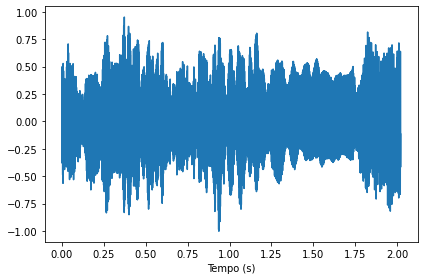

In [78]:
dft_out = spectrum * transfer
output = dft_out.make_wave()
output.normalize()
output.plot()
tdsp.decorate(xlabel='Tempo (s)')
output.make_audio()

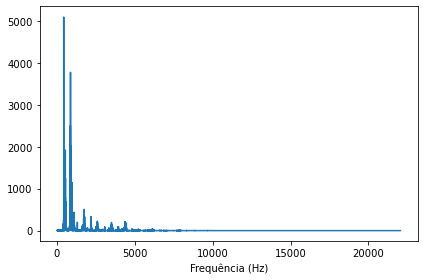

In [41]:
spectrum = output.make_spectrum()
spectrum.plot()
tdsp.decorate(xlabel='Frequência (Hz)')

Nesse exemplo, ignoramos um fato que é digno de menção. A gravação do violino que utilizamos já foi transformada por um sistema: a sala onde foi gravada. Então, o que realmente calculamos nesse exemplo é o som do violino após duas transformações. Para simular adequadamente o som de um violino em uma sala diferente, eu deveria ter caracterizado a sala onde o violino foi gravado e aplicado antes o inverso dessa função de transferência.

## **Sistemas e convolução**

Podemos entender essa representação de sistemas LIT no seguinte contexto:

- O espectro de um **impulso** possui componentes com amplitude 1 em todas as frequências.
- A **resposta ao impulso** (domínio do tempo) contém a soma das respostas do sistema a todos esses componentes.
- A **função de transferência**, que é o DFT da resposta ao impulso, codifica o efeito do sistema em cada componente de frequência na forma de um multiplicador de amplitude e uma mudança de fase.
- Para qualquer entrada, podemos calcular a resposta do sistema dividindo a entrada em componentes, calculando a resposta para cada componente e somando-os.

Pelo Teorema da Convolução, a multiplicação no domínio da frequência corresponde à convolução no domínio do tempo. A saída do sistema é, portanto, a convolução entre a entrada e a resposta do sistema.

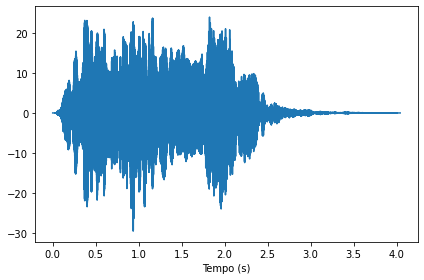

In [80]:
new_violin = violin.convolve(response)
new_violin.plot()
tdsp.decorate(xlabel='Tempo (s)')

new_violin.make_audio()

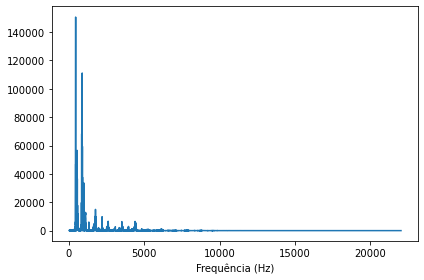

In [82]:
new_violin.make_spectrum().plot()
tdsp.decorate(xlabel='Frequência (Hz)')

Daí a importância da operação e do **teorema da convolução**; ao caracterizarmos um sistema com sua **resposta ao impulso** e/ou sua **função de transferência**, poderemos simular a saída desse sistema para qualquer entrada que desejarmos.

---
---